In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Import from the updated module
register_matplotlib_converters()
from time import time


## Catfish sales data

In [2]:
catfish_sales = pd.read_csv(
    r"D:\Time series analysis\catfish.csv",
    parse_dates=[0],
    index_col=0,
    date_format='%Y-%m-%d'  # Use date_format instead of date_parser if applicable
)

In [3]:
#infer the frequency of the data
catfish_sales=catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [4]:
catfish_sales.squeeze()

Date
1986-01-01     9034
1986-02-01     9596
1986-03-01    10558
1986-04-01     9002
1986-05-01     9239
              ...  
2012-08-01    14442
2012-09-01    13422
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 324, dtype: int64

In [5]:
start_date=pd.to_datetime('1996-1-01')
end_date=pd.to_datetime('2000-1-01')
lim_catfish_sales=catfish_sales[start_date:end_date]

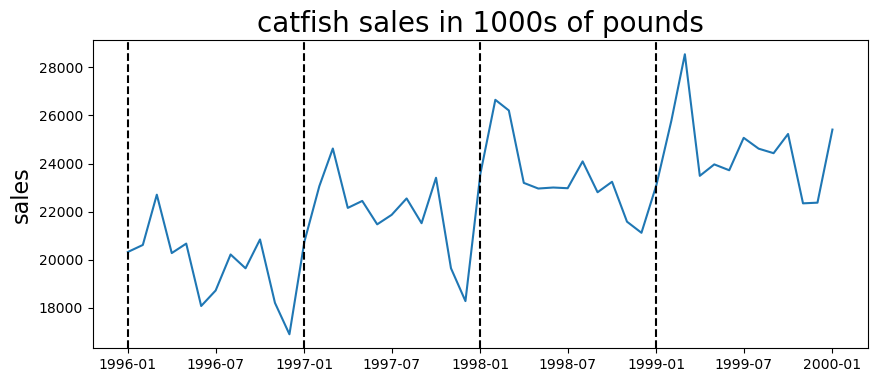

In [6]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('catfish sales in 1000s of pounds' , fontsize=20)
plt.ylabel('sales',fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')

## Remove the trend

In [7]:
first_diff=lim_catfish_sales.diff()[1:]


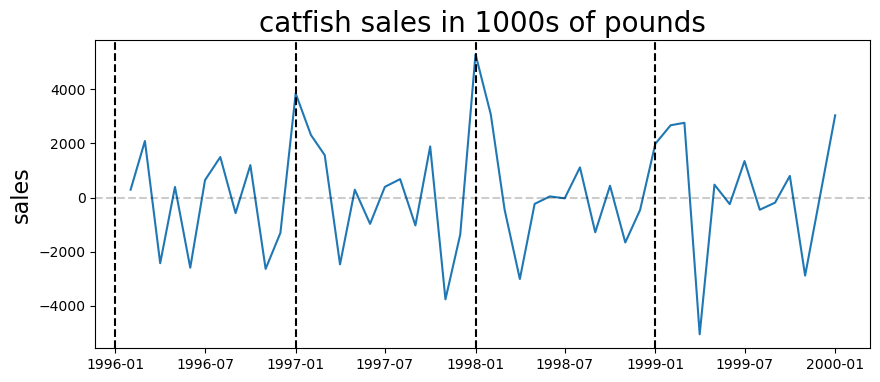

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('catfish sales in 1000s of pounds' , fontsize=20)
plt.ylabel('sales',fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--')
plt.axhline(0,color='k',linestyle='--',alpha=0.2)

## we have taken first diff so integrated model here we take is 1

## ACF

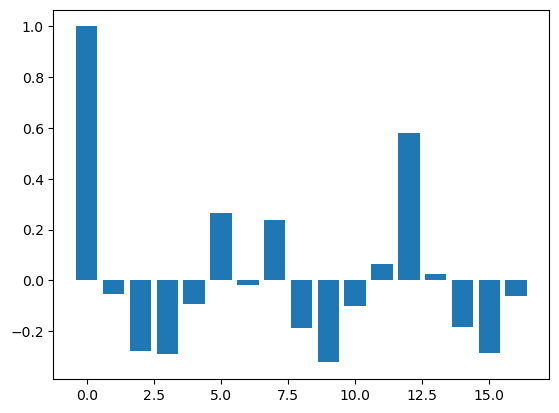

In [10]:
acf_vals = acf(first_diff)
num_lags = min(20, len(acf_vals))  # Adjust num_lags to be at most the length of acf_vals
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()


## Based on ACF, we should start with a seasonal MA process

## PACF

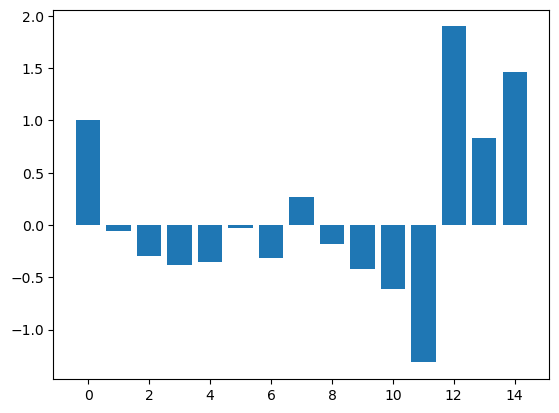

In [12]:
pacf_vals = pacf(first_diff)
num_lags = min(15, len(pacf_vals))  # Adjust num_lags to be at most the length of acf_vals
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.show()

## Based on pacf , we should satrt with a seosonal AR process

## Get training and testing sets

In [14]:
train_end=datetime(1999,7,1)#training data from 2010 to 2018 last
test_end=datetime(2000,1,1)#test data from 2019 satring to 2019 ending
train_data=lim_catfish_sales[:train_end]
test_data=lim_catfish_sales[train_end+timedelta(days=1):test_end]

## Fit the SARIMA model

In [16]:
my_order = (0,1,0) #non-seosonal part
my_seasonal_order = (1, 0, 1, 12) #seosonal part
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [19]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.20579051971435547


C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [20]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Tue, 13 Aug 2024   AIC                            737.269
Time:                                      23:32:24   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.847      0.000       0.589       1.061
ma.S.L12      -0.51

In [22]:
#get prediction and residuals
predictions=model_fit.forecast(len(test_data))
predictions=pd.Series(predictions,index=test_data.index)
residuals=test_data-predictions

In [24]:
print(test_data.head())

            Total
Date             
1999-08-01  24618
1999-09-01  24430
1999-10-01  25229
1999-11-01  22344
1999-12-01  22372


In [25]:
print(predictions.head())

Date
1999-08-01    25695.470325
1999-09-01    25054.173652
1999-10-01    25642.819422
1999-11-01    24195.592236
1999-12-01    23677.362247
Freq: MS, Name: predicted_mean, dtype: float64


In [26]:
print(residuals.head())

            Total  1999-08-01 00:00:00  1999-09-01 00:00:00  \
Date                                                          
1999-08-01    NaN                  NaN                  NaN   
1999-09-01    NaN                  NaN                  NaN   
1999-10-01    NaN                  NaN                  NaN   
1999-11-01    NaN                  NaN                  NaN   
1999-12-01    NaN                  NaN                  NaN   

            1999-10-01 00:00:00  1999-11-01 00:00:00  1999-12-01 00:00:00  \
Date                                                                        
1999-08-01                  NaN                  NaN                  NaN   
1999-09-01                  NaN                  NaN                  NaN   
1999-10-01                  NaN                  NaN                  NaN   
1999-11-01                  NaN                  NaN                  NaN   
1999-12-01                  NaN                  NaN                  NaN   

            2000-0

In [27]:
predictions = predictions.squeeze()  # Convert predictions to Series if it's not already
test_data = test_data.squeeze()      # Convert test_data to Series if it's not already

# Check the indices
print(test_data.index)
print(predictions.index)

DatetimeIndex(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
               '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')
DatetimeIndex(['1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01',
               '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')


In [28]:
residuals = test_data - predictions
print(residuals.head())  # This s

Date
1999-08-01   -1077.470325
1999-09-01    -624.173652
1999-10-01    -413.819422
1999-11-01   -1851.592236
1999-12-01   -1305.362247
Freq: MS, dtype: float64


Text(0, 0.5, 'Error')

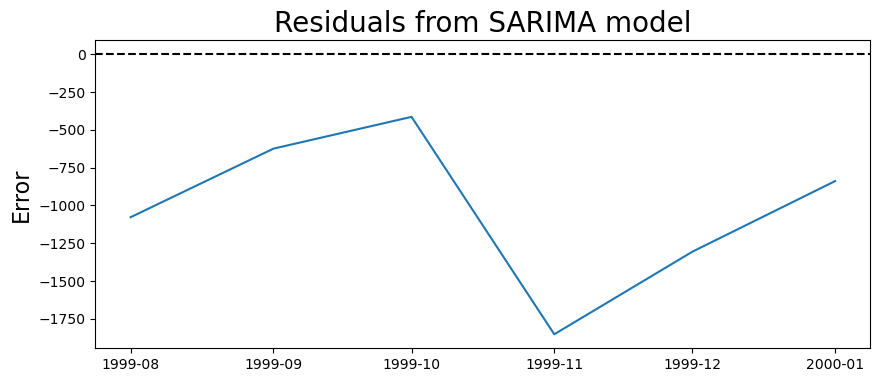

In [29]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0,linestyle='--',color='k')
plt.title("Residuals from SARIMA model", fontsize=20)
plt.ylabel('Error',fontsize=16)

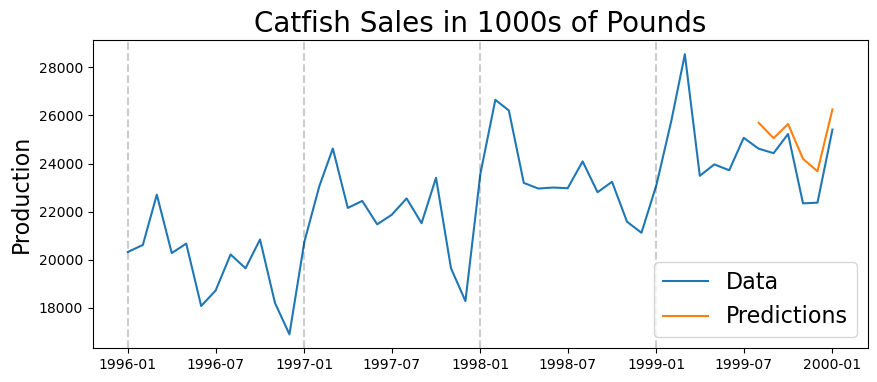

In [31]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [32]:
print('Mean absolute percent error:', round(np.mean(abs(residuals/test_data)),4))

Mean absolute percent error: 0.0433


In [33]:
print('Root mean sqaure Error', np.sqrt(np.mean(residuals**2)))

Root mean sqaure Error 1122.2784645391189


## Rolling forecast origin

In [37]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_catfish_sales[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\ASHU\AppData\Local\Temp\ipykernel_10396\3978322752.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[25695.47032456]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rolling_predictions[train_end] = pred
C:\Users\ASHU\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters

In [39]:
rolling_residuals=test_data-rolling_predictions

Text(0, 0.5, 'Error')

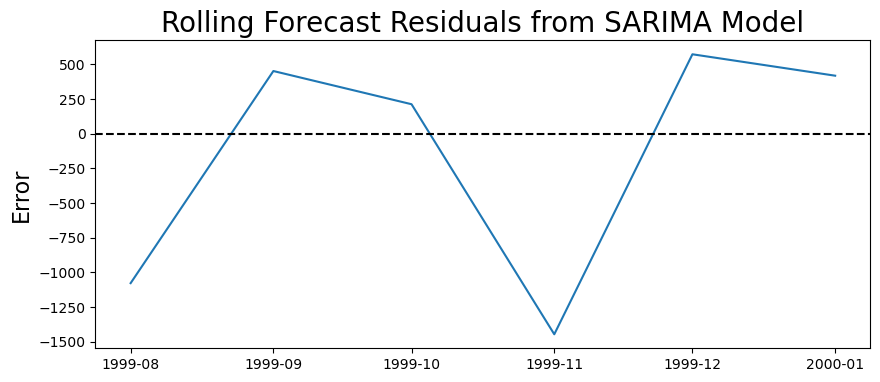

In [40]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

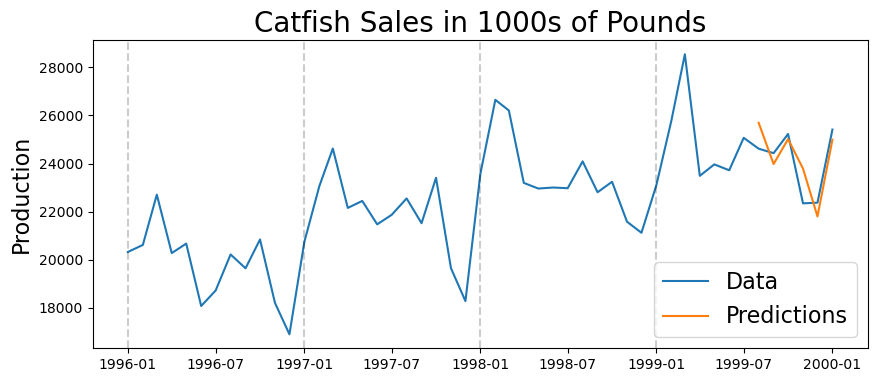

In [41]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [44]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))


Mean Absolute Percent Error: 0.0296


In [45]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))


Root Mean Squared Error: 816.8941118560873
